<a href="https://colab.research.google.com/github/Jeong-HyunLee/GOBE-Reef-diversity/blob/main/GOBE_Reef_statistics_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Cell 1: Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = [12, 8]

# In Google Colab, Arial font might not be available
# Let's set a fallback mechanism for fonts and suppress specific font warnings
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial', 'sans-serif']
# Filter out font warnings specifically
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
#@title Cell 2: Define Ordovician Stages and Constants

# Define the Ordovician stages with their boundaries (in Ma)
# Values from International Commission on Stratigraphy (2023)
ordovician_stages = {
    'Hirnantian': (443.8, 445.2),    # Upper Ordovician (Uppermost)
    'Katian': (445.2, 453.0),        # Upper Ordovician
    'Sandbian': (453.0, 458.4),      # Upper Ordovician
    'Darriwilian': (458.4, 467.3),   # Middle Ordovician
    'Dapingian': (467.3, 470.0),     # Middle Ordovician
    'Floian': (470.0, 477.7),        # Lower Ordovician
    'Tremadocian': (477.7, 485.4)    # Lower Ordovician (Lowermost)
}

# Calculate midpoint age for each stage
stage_midpoints = {stage: (start + end) / 2 for stage, (end, start) in ordovician_stages.items()}

# Create a DataFrame for easier handling
stages_df = pd.DataFrame([
    {'stage': stage, 'start_age': bounds[1], 'end_age': bounds[0], 'mid_age': (bounds[0] + bounds[1]) / 2}
    for stage, bounds in ordovician_stages.items()
])

# Add epoch information
stages_df['epoch'] = pd.Categorical(['Upper', 'Upper', 'Upper', 'Middle', 'Middle', 'Lower', 'Lower'],
                                   categories=['Lower', 'Middle', 'Upper'],
                                   ordered=True)

# Sort by age (oldest to youngest)
stages_df = stages_df.sort_values('start_age', ascending=False).reset_index(drop=True)

print("Ordovician stages defined:")
print(stages_df)

Ordovician stages defined:
         stage  start_age  end_age  mid_age   epoch
0  Tremadocian      485.4    477.7   481.55   Lower
1       Floian      477.7    470.0   473.85   Lower
2    Dapingian      470.0    467.3   468.65  Middle
3  Darriwilian      467.3    458.4   462.85  Middle
4     Sandbian      458.4    453.0   455.70   Upper
5       Katian      453.0    445.2   449.10   Upper
6   Hirnantian      445.2    443.8   444.50   Upper


Retrieved 2820 geological units from Macrostrat API.
Unique geometry types: ['Point']
Filtered to 1996 carbonate units.


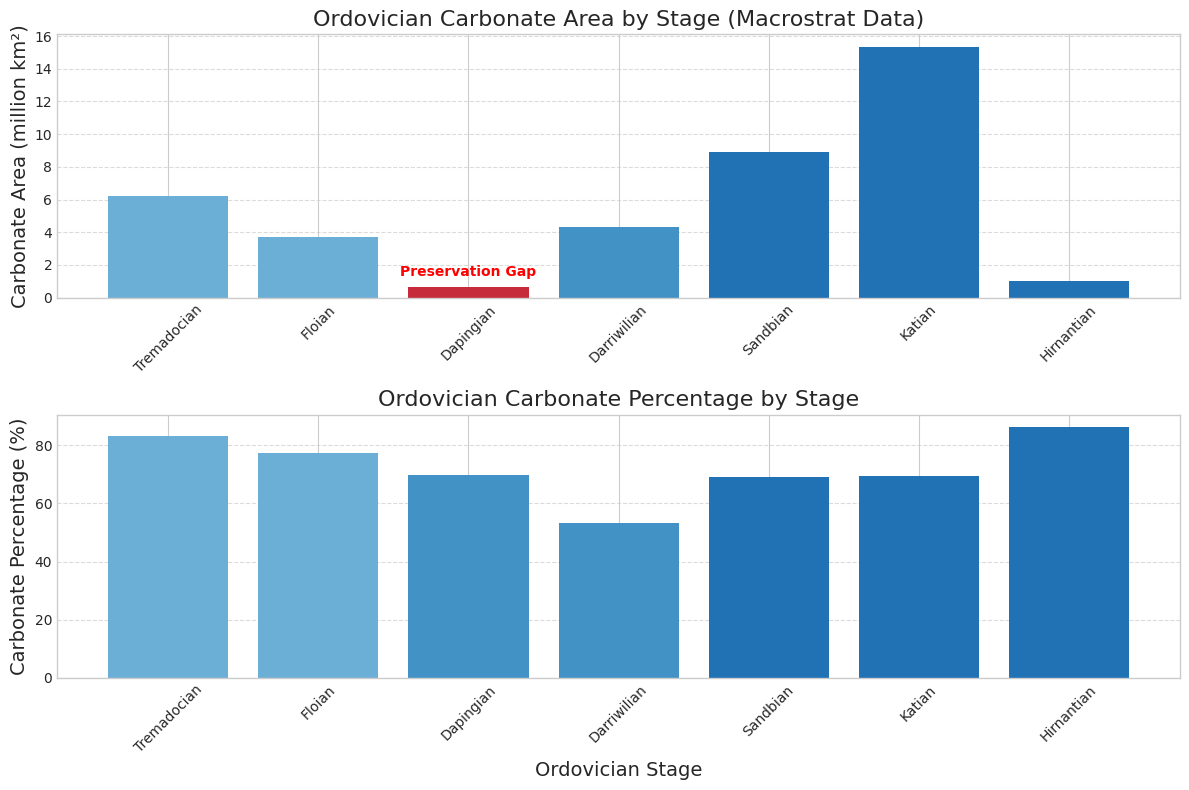


Generated macrostrat_data:
         stage  start_age  end_age  mid_age   epoch  total_area_km2  \
0  Tremadocian      485.4    477.7   481.55   Lower    7.454829e+06   
1       Floian      477.7    470.0   473.85   Lower    4.774902e+06   
2    Dapingian      470.0    467.3   468.65  Middle    9.107677e+05   
3  Darriwilian      467.3    458.4   462.85  Middle    8.050362e+06   
4     Sandbian      458.4    453.0   455.70   Upper    1.289061e+07   
5       Katian      453.0    445.2   449.10   Upper    2.213258e+07   
6   Hirnantian      445.2    443.8   444.50   Upper    1.160944e+06   

   carbonate_area_km2  carbonate_percentage  
0        6.192608e+06             83.068410  
1        3.691614e+06             77.312861  
2        6.364878e+05             69.884758  
3        4.296837e+06             53.374458  
4        8.882741e+06             68.908627  
5        1.533921e+07             69.306025  
6        1.001186e+06             86.239002  

Saved macrostrat_data to 'macrostr

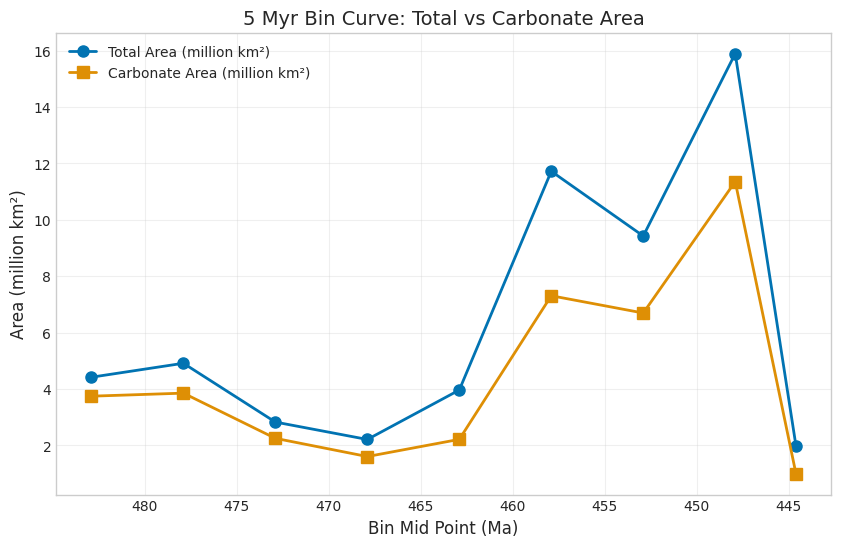

In [ ]:
#@title Cell 3: Process Real Macrostrat Data, Create 5 Myr Bins, and Save Vector-Image PDFs

import requests
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Retrieve Macrostrat Data
# ----------------------------
url = "https://macrostrat.org/api/units?interval_name=Ordovician&format=geojson&response=long"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    features = data.get("success", {}).get("data", [])
    units = gpd.GeoDataFrame.from_features(features)
    print(f"Retrieved {len(units)} geological units from Macrostrat API.")
else:
    raise ConnectionError(f"Failed to retrieve data. Status code: {response.status_code}")

# ----------------------------
# Set CRS and Calculate Area & Age
# ----------------------------
if units.crs is None:
    units.set_crs(epsg=4326, inplace=True)
units = units.to_crs(epsg=3857)

print("Unique geometry types:", units.geometry.geom_type.unique())
if all(g == "Point" for g in units.geometry.geom_type):
    units['area_km2'] = pd.to_numeric(units['col_area'], errors='coerce')
else:
    units['area_km2'] = units.geometry.area / 1e6

# Calculate the midpoint age for each unit and drop rows without mid_age
units['mid_age'] = (units['t_age'] + units['b_age']) / 2.0
units.dropna(subset=['mid_age'], inplace=True)

# ----------------------------
# Identify Carbonate Units
# ----------------------------
def check_if_carbonate(lithologies):
    if isinstance(lithologies, list):
        for lith in lithologies:
            if 'type' in lith and 'carbonate' in lith['type'].lower():
                return True
    return False

units['is_carbonate'] = units['lith'].apply(check_if_carbonate)
carbonate_units = units[units['is_carbonate']]
print(f"Filtered to {len(carbonate_units)} carbonate units.")

# ----------------------------
# Aggregate Data by Ordovician Stage
# (Assumes Cell 2 defined 'ordovician_stages' and 'stages_df')
# ----------------------------
def assign_stage(age):
    for stage, (end, start) in ordovician_stages.items():
        if start >= age >= end:
            return stage
    return None

units['stage'] = units['mid_age'].apply(assign_stage)
carbonate_units['stage'] = carbonate_units['mid_age'].apply(assign_stage)

stage_totals = units.groupby('stage')['area_km2'].sum().reset_index()
stage_totals.rename(columns={'area_km2': 'total_area_km2'}, inplace=True)
stage_carbonates = carbonate_units.groupby('stage')['area_km2'].sum().reset_index()
stage_carbonates.rename(columns={'area_km2': 'carbonate_area_km2'}, inplace=True)

stage_summary = pd.merge(stage_totals, stage_carbonates, on='stage', how='left')
stage_summary['carbonate_area_km2'] = stage_summary['carbonate_area_km2'].fillna(0)
stage_summary['carbonate_percentage'] = (stage_summary['carbonate_area_km2'] / stage_summary['total_area_km2']) * 100

macrostrat_data = pd.merge(stages_df[['stage', 'start_age', 'end_age', 'mid_age', 'epoch']],
                           stage_summary, on='stage', how='left')
macrostrat_data = macrostrat_data.sort_values('start_age', ascending=False).reset_index(drop=True)

# ----------------------------
# Plot Stage-Based Bar Plots
# ----------------------------
plt.figure(figsize=(12, 8))

# Bar plot: Carbonate Area by Stage
ax1 = plt.subplot(211)
ax1.bar(macrostrat_data['stage'], macrostrat_data['carbonate_area_km2']/1e6,
       color=[{'Lower': '#6baed6', 'Middle': '#4292c6', 'Upper': '#2171b5'}[e] for e in macrostrat_data['epoch']])
ax1.set_title('Ordovician Carbonate Area by Stage (Macrostrat Data)', fontsize=16)
ax1.set_ylabel('Carbonate Area (million km²)', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the Dapingian stage (preservation gap)
dapingian_idx = macrostrat_data[macrostrat_data['stage'] == 'Dapingian'].index
if not dapingian_idx.empty:
    dapingian_row = dapingian_idx[0]
    dapingian_value = macrostrat_data.loc[dapingian_row, 'carbonate_area_km2']/1e6
    ax1.bar(dapingian_row, dapingian_value, color='red', alpha=0.7)
    ax1.text(dapingian_row, dapingian_value + 0.5, 'Preservation Gap',
             ha='center', va='bottom', color='red', fontweight='bold')

# Bar plot: Carbonate Percentage by Stage
ax2 = plt.subplot(212, sharex=ax1)
ax2.bar(macrostrat_data['stage'], macrostrat_data['carbonate_percentage'],
       color=[{'Lower': '#6baed6', 'Middle': '#4292c6', 'Upper': '#2171b5'}[e] for e in macrostrat_data['epoch']])
ax2.set_title('Ordovician Carbonate Percentage by Stage', fontsize=16)
ax2.set_ylabel('Carbonate Percentage (%)', fontsize=14)
ax2.set_xlabel('Ordovician Stage', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('macrostrat_data_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\nGenerated macrostrat_data:")
print(macrostrat_data)
macrostrat_data.to_csv('macrostrat_data.csv', index=False)
print("\nSaved macrostrat_data to 'macrostrat_data.csv'")

# ----------------------------
# Create 5 Myr Bin Summary from Macrostrat Data
# ----------------------------
# Define manual bins spanning 485.4 to 443.8 Ma
manual_bins = [443.8, 445.4, 450.4, 455.4, 460.4, 465.4, 470.4, 475.4, 480.4, 485.4]

# For all units:
units['time_bin'] = pd.cut(units['mid_age'], bins=manual_bins, include_lowest=True, right=True)
macro_all_5myr_summary = units.groupby('time_bin')['area_km2'].sum().reset_index()
macro_all_5myr_summary.rename(columns={'area_km2': 'total_area_km2_all'}, inplace=True)

# For carbonate units:
carbonate_units['time_bin'] = pd.cut(carbonate_units['mid_age'], bins=manual_bins, include_lowest=True, right=True)
macro_carbonate_5myr_summary = carbonate_units.groupby('time_bin')['area_km2'].sum().reset_index()
macro_carbonate_5myr_summary.rename(columns={'area_km2': 'total_area_km2_carbonate'}, inplace=True)

# Merge the two summaries using the common bin
macrostrat_5myr_summary = pd.merge(macro_all_5myr_summary, macro_carbonate_5myr_summary,
                                   on='time_bin', how='left')
macrostrat_5myr_summary['carbonate_area_km2'] = macrostrat_5myr_summary['total_area_km2_carbonate'].fillna(0)
macrostrat_5myr_summary['carbonate_percentage'] = (macrostrat_5myr_summary['carbonate_area_km2'] /
                                                   macrostrat_5myr_summary['total_area_km2_all']) * 100
macrostrat_5myr_summary['bin_mid'] = macrostrat_5myr_summary['time_bin'].apply(
    lambda x: (x.left + x.right) / 2).round(1)

print("\nMacrostrat 5 Myr bin summary:")
print(macrostrat_5myr_summary)

# ----------------------------
# Plot 5 Myr Bin Curve for Total Area and Carbonate Area
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(macrostrat_5myr_summary['bin_mid'], macrostrat_5myr_summary['total_area_km2_all']/1e6,
         'o-', linewidth=2, markersize=8, label='Total Area (million km²)')
plt.plot(macrostrat_5myr_summary['bin_mid'], macrostrat_5myr_summary['carbonate_area_km2']/1e6,
         's-', linewidth=2, markersize=8, label='Carbonate Area (million km²)')
plt.xlabel('Bin Mid Point (Ma)', fontsize=12)
plt.ylabel('Area (million km²)', fontsize=12)
plt.title('5 Myr Bin Curve: Total vs Carbonate Area', fontsize=14)
plt.legend(loc='best')
plt.gca().invert_xaxis()
plt.grid(True, alpha=0.3)
plt.show()


Saving df_bryozoa.csv to df_bryozoa.csv
Saving df_rugosa.csv to df_rugosa.csv
Saving df_stromatoporoid.csv to df_stromatoporoid.csv
Saving df_tabulata.csv to df_tabulata.csv
Saving reef_occurrence.csv to reef_occurrence.csv
df_tabulata columns: Index(['interval_no', 'interval_name', 'max_ma', 'min_ma', 'X_Ft', 'X_bL',
       'X_FL', 'X_bt', 'sampled_in_bin', 'implied_in_bin', 'n_occs'],
      dtype='object')
df_stromatoporoid columns: Index(['interval_no', 'interval_name', 'max_ma', 'min_ma', 'X_Ft', 'X_bL',
       'X_FL', 'X_bt', 'sampled_in_bin', 'implied_in_bin', 'n_occs'],
      dtype='object')
df_rugosa columns: Index(['interval_no', 'interval_name', 'max_ma', 'min_ma', 'X_Ft', 'X_bL',
       'X_FL', 'X_bt', 'sampled_in_bin', 'implied_in_bin', 'n_occs'],
      dtype='object')
df_bryozoa columns: Index(['interval_no', 'interval_name', 'max_ma', 'min_ma', 'X_Ft', 'X_bL',
       'X_FL', 'X_bt', 'sampled_in_bin', 'implied_in_bin', 'n_occs'],
      dtype='object')
reef_occurrence colum

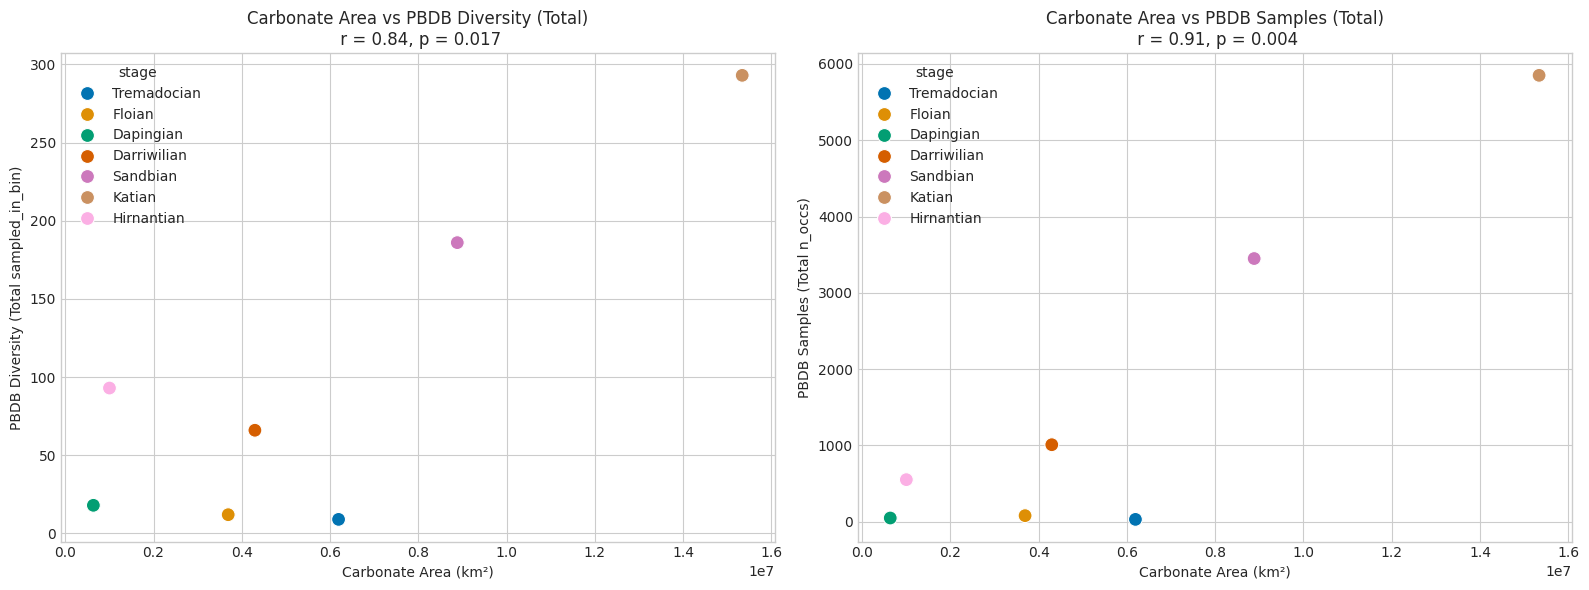

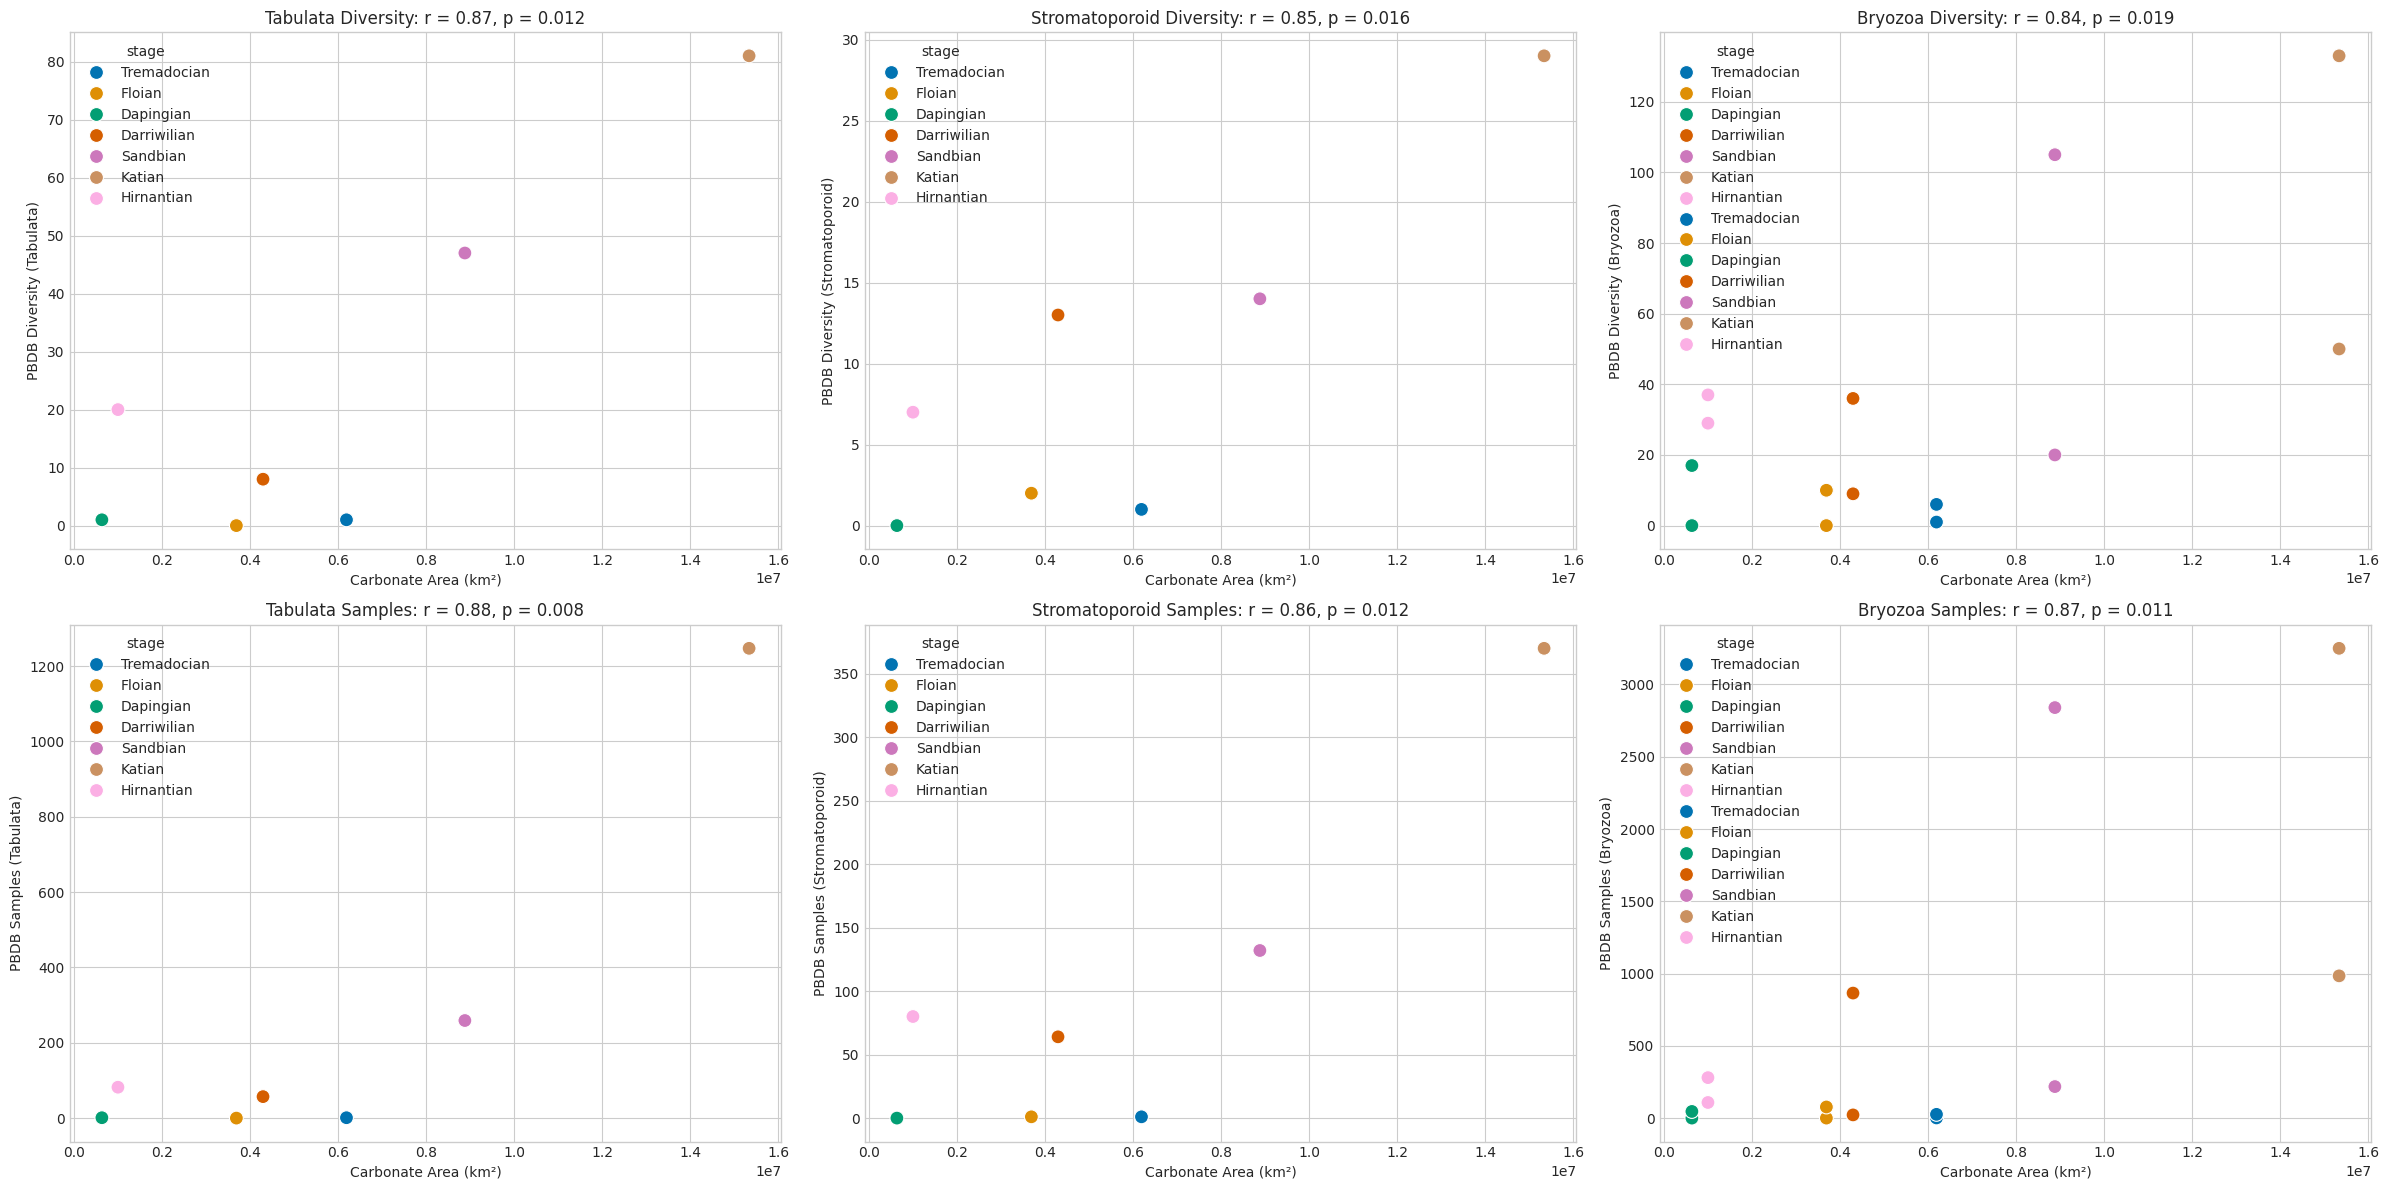

In [ ]:
#@title Cell 4: Stage-level Comparisons

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import io
from google.colab import files

# ----- Upload Files -----
# Please upload the following files:
#   - df_tabulata.csv
#   - df_stromatoporoid.csv
#   - df_rugosa.csv
#   - df_bryozoa.csv
#   - reef_occurrence.csv
uploaded = files.upload()

# Helper function: return the file content from the uploaded dict if the base string is in the key.
def get_uploaded_file(base_name):
    for key in uploaded.keys():
        if base_name in key and key.endswith('.csv'):
            return uploaded[key]
    raise KeyError(f"No uploaded file found containing '{base_name}'")

# ----- Load Files from Uploaded Data -----
# For the PBDB files, we skip the first 21 rows so that row 22 becomes the header.
df_tabulata = pd.read_csv(io.BytesIO(get_uploaded_file('df_tabulata')), skiprows=21)
df_stromatoporoid = pd.read_csv(io.BytesIO(get_uploaded_file('df_stromatoporoid')), skiprows=21)
df_rugosa = pd.read_csv(io.BytesIO(get_uploaded_file('df_rugosa')), skiprows=21)
df_bryozoa = pd.read_csv(io.BytesIO(get_uploaded_file('df_bryozoa')), skiprows=21)

# For reef_occurrence, the header is on the first row.
reef_occurrence = pd.read_csv(io.BytesIO(get_uploaded_file('reef_occurrence')))

# ----- Verify the Loaded Columns -----
print("df_tabulata columns:", df_tabulata.columns)
print("df_stromatoporoid columns:", df_stromatoporoid.columns)
print("df_rugosa columns:", df_rugosa.columns)
print("df_bryozoa columns:", df_bryozoa.columns)
print("reef_occurrence columns:", reef_occurrence.columns)

# ----- Section 1: Aggregate PBDB Data by Stage for Each Group -----
# "interval_name" is used to indicate the stage.
# "sampled_in_bin" is the diversity measure and "n_occs" is the number of samples.

# -- Diversity Aggregation --
div_tabulata = (df_tabulata.groupby("interval_name")["sampled_in_bin"]
                .sum()
                .reset_index()
                .rename(columns={"sampled_in_bin": "pbdb_div_tabulata"}))
div_stromatoporoid = (df_stromatoporoid.groupby("interval_name")["sampled_in_bin"]
                       .sum()
                       .reset_index()
                       .rename(columns={"sampled_in_bin": "pbdb_div_stromatoporoid"}))
div_rugosa = (df_rugosa.groupby("interval_name")["sampled_in_bin"]
              .sum()
              .reset_index()
              .rename(columns={"sampled_in_bin": "pbdb_div_rugosa"}))
div_bryozoa = (df_bryozoa.groupby("interval_name")["sampled_in_bin"]
              .sum()
              .reset_index()
              .rename(columns={"sampled_in_bin": "pbdb_div_bryozoa"}))

# -- Samples Aggregation --
samples_tabulata = (df_tabulata.groupby("interval_name")["n_occs"]
                    .sum()
                    .reset_index()
                    .rename(columns={"n_occs": "pbdb_samples_tabulata"}))
samples_stromatoporoid = (df_stromatoporoid.groupby("interval_name")["n_occs"]
                          .sum()
                          .reset_index()
                          .rename(columns={"n_occs": "pbdb_samples_stromatoporoid"}))
samples_rugosa = (df_rugosa.groupby("interval_name")["n_occs"]
                  .sum()
                  .reset_index()
                  .rename(columns={"n_occs": "pbdb_samples_rugosa"}))
samples_bryozoa = (df_bryozoa.groupby("interval_name")["n_occs"]
                  .sum()
                  .reset_index()
                  .rename(columns={"n_occs": "pbdb_samples_bryozoa"}))

# Merge diversity data across groups.
pbdb_div_agg = div_tabulata.merge(div_stromatoporoid, on="interval_name", how="outer")
pbdb_div_agg = pbdb_div_agg.merge(div_rugosa, on="interval_name", how="outer")
pbdb_div_agg = pbdb_div_agg.merge(div_bryozoa, on="interval_name", how="outer")
pbdb_div_agg = pbdb_div_agg.rename(columns={"interval_name": "stage"})

# Merge sample data across groups.
pbdb_samples_agg = samples_tabulata.merge(samples_stromatoporoid, on="interval_name", how="outer")
pbdb_samples_agg = pbdb_samples_agg.merge(samples_rugosa, on="interval_name", how="outer")
pbdb_samples_agg = pbdb_samples_agg.merge(samples_bryozoa, on="interval_name", how="outer")
pbdb_samples_agg = pbdb_samples_agg.rename(columns={"interval_name": "stage"})

# Compute totals across groups.
pbdb_div_agg["pbdb_div_total"] = (pbdb_div_agg["pbdb_div_tabulata"].fillna(0) +
                                  pbdb_div_agg["pbdb_div_stromatoporoid"].fillna(0) +
                                  pbdb_div_agg["pbdb_div_rugosa"].fillna(0) + # Corrected indentation
                                  pbdb_div_agg["pbdb_div_bryozoa"].fillna(0)) # Corrected indentation
pbdb_samples_agg["pbdb_samples_total"] = (pbdb_samples_agg["pbdb_samples_tabulata"].fillna(0) +
                                          pbdb_samples_agg["pbdb_samples_stromatoporoid"].fillna(0) +
                                          pbdb_samples_agg["pbdb_samples_rugosa"].fillna(0) + # Corrected indentation
                                          pbdb_samples_agg["pbdb_samples_bryozoa"].fillna(0)) # Corrected indentation

print("\nAggregated PBDB Diversity Data by Stage:")
print(pbdb_div_agg)
print("\nAggregated PBDB Sample Data by Stage:")
print(pbdb_samples_agg)

# ----- Section 2: Aggregated Data from Other Sources -----
# Macrostrat data is assumed to be available as macrostrat_data with a "stage" column.
print("\nMacrostrat Data by Stage (All Rows):")
print(macrostrat_data)

# Kiessling reef occurrence data: expected columns include "Series", "Stage", "Reefs #", and "Reef # / Ma".
kiessling_stage = (reef_occurrence.groupby("Stage")
                   .agg({
                       "Reefs #": "sum",      # Total reefs per stage
                       "Reef # / Ma": "mean"   # Average reef density per stage
                   })
                   .reset_index()
                   .rename(columns={"Stage": "stage",
                                    "Reefs #": "kiessling_reefs",
                                    "Reef # / Ma": "kiessling_density"}))
print("\nKiessling Reef Occurrence Data Aggregated by Stage (All Rows):")
print(kiessling_stage)

# ----- Section 3: Merge All Data by Stage -----
# Merge Macrostrat data with PBDB diversity and sample aggregates.
merged_div = pd.merge(macrostrat_data, pbdb_div_agg, on="stage", how="inner")
merged_div = pd.merge(merged_div, kiessling_stage, on="stage", how="inner")

merged_samples = pd.merge(macrostrat_data, pbdb_samples_agg, on="stage", how="inner")
merged_samples = pd.merge(merged_samples, kiessling_stage, on="stage", how="inner")

print("\nMerged Data by Stage (Diversity):")
print(merged_div)
print("\nMerged Data by Stage (Samples):")
print(merged_samples)

# ----- Section 4: Compute Correlations -----
# Convert necessary columns to numeric.
cols_div = ["carbonate_area_km2", "carbonate_percentage", "pbdb_div_total",
            "pbdb_div_tabulata", "pbdb_div_stromatoporoid", "pbdb_div_rugosa","pbdb_div_bryozoa",
            "kiessling_reefs"]
for col in cols_div:
    merged_div[col] = pd.to_numeric(merged_div[col], errors="coerce")

cols_samples = ["carbonate_area_km2", "carbonate_percentage", "pbdb_samples_total",
                "pbdb_samples_tabulata", "pbdb_samples_stromatoporoid", "pbdb_samples_rugosa", "pbdb_samples_bryozoa",
                "kiessling_reefs"]
for col in cols_samples:
    merged_samples[col] = pd.to_numeric(merged_samples[col], errors="coerce")

# Aggregated correlations:
div_total_r, div_total_p = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_total"])
reef_div_r, reef_div_p = pearsonr(merged_div["carbonate_area_km2"], merged_div["kiessling_reefs"])

samples_total_r, samples_total_p = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_total"])
reef_samples_r, reef_samples_p = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["kiessling_reefs"])

print("\nAggregated Diversity Correlations:")
print(f"Carbonate area vs PBDB Diversity (Total): r = {div_total_r:.2f}, p = {div_total_p:.3f}")
print(f"Carbonate area vs Kiessling Reef Occurrence: r = {reef_div_r:.2f}, p = {reef_div_p:.3f}")

print("\nAggregated Samples Correlations:")
print(f"Carbonate area vs PBDB Samples (Total): r = {samples_total_r:.2f}, p = {samples_total_p:.3f}")
print(f"Carbonate area vs Kiessling Reef Occurrence: r = {reef_samples_r:.2f}, p = {reef_samples_p:.3f}")

# Individual group correlations for Diversity:
r_div_tabulata, p_div_tabulata = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_tabulata"])
r_div_stromatoporoid, p_div_stromatoporoid = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_stromatoporoid"])
r_div_rugosa, p_div_rugosa = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_rugosa"])
r_div_bryozoa, p_div_bryozoa = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_bryozoa"])

print("\nIndividual Diversity Correlations:")
print(f"Carbonate area vs PBDB Diversity (Tabulata): r = {r_div_tabulata:.2f}, p = {p_div_tabulata:.3f}")
print(f"Carbonate area vs PBDB Diversity (Stromatoporoid): r = {r_div_stromatoporoid:.2f}, p = {p_div_stromatoporoid:.3f}")
print(f"Carbonate area vs PBDB Diversity (Rugosa): r = {r_div_rugosa:.2f}, p = {p_div_rugosa:.3f}")
print(f"Carbonate area vs PBDB Diversity (Bryozoa): r = {r_div_bryozoa:.2f}, p = {p_div_bryozoa:.3f}")

# Individual group correlations for Samples:
r_samples_tabulata, p_samples_tabulata = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_tabulata"])
r_samples_stromatoporoid, p_samples_stromatoporoid = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_stromatoporoid"])
r_samples_rugosa, p_samples_rugosa = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_rugosa"])
r_samples_bryozoa, p_samples_bryozoa = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_bryozoa"])

print("\nIndividual Samples Correlations:")
print(f"Carbonate area vs PBDB Samples (Tabulata): r = {r_samples_tabulata:.2f}, p = {p_samples_tabulata:.3f}")
print(f"Carbonate area vs PBDB Samples (Stromatoporoid): r = {r_samples_stromatoporoid:.2f}, p = {p_samples_stromatoporoid:.3f}")
print(f"Carbonate area vs PBDB Samples (Rugosa): r = {r_samples_rugosa:.2f}, p = {p_samples_rugosa:.3f}")
print(f"Carbonate area vs PBDB Samples (Bryozoa): r = {r_samples_bryozoa:.2f}, p = {p_samples_bryozoa:.3f}")

# ----- Section 5: Plotting -----
# Plot aggregated diversity and samples comparisons.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_total", hue="stage", ax=axes[0], s=100)
axes[0].set_title(f"Carbonate Area vs PBDB Diversity (Total)\n r = {div_total_r:.2f}, p = {div_total_p:.3f}")
axes[0].set_xlabel("Carbonate Area (km²)")
axes[0].set_ylabel("PBDB Diversity (Total sampled_in_bin)")

sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_total", hue="stage", ax=axes[1], s=100)
axes[1].set_title(f"Carbonate Area vs PBDB Samples (Total)\n r = {samples_total_r:.2f}, p = {samples_total_p:.3f}")
axes[1].set_xlabel("Carbonate Area (km²)")
axes[1].set_ylabel("PBDB Samples (Total n_occs)")

plt.tight_layout()
plt.show()

# Additional Plot: Individual Group Comparisons (2x3 panel)
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

# Diversity plots
sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_tabulata", hue="stage", ax=axes[0,0], s=100)
axes[0,0].set_title(f"Tabulata Diversity: r = {r_div_tabulata:.2f}, p = {p_div_tabulata:.3f}")
axes[0,0].set_xlabel("Carbonate Area (km²)")
axes[0,0].set_ylabel("PBDB Diversity (Tabulata)")

sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_stromatoporoid", hue="stage", ax=axes[0,1], s=100)
axes[0,1].set_title(f"Stromatoporoid Diversity: r = {r_div_stromatoporoid:.2f}, p = {p_div_stromatoporoid:.3f}")
axes[0,1].set_xlabel("Carbonate Area (km²)")
axes[0,1].set_ylabel("PBDB Diversity (Stromatoporoid)")

sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_rugosa", hue="stage", ax=axes[0,2], s=100)
axes[0,2].set_title(f"Rugosa Diversity: r = {r_div_rugosa:.2f}, p = {p_div_rugosa:.3f}")
axes[0,2].set_xlabel("Carbonate Area (km²)")
axes[0,2].set_ylabel("PBDB Diversity (Rugosa)")

sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_bryozoa", hue="stage", ax=axes[0,2], s=100)
axes[0,2].set_title(f"Bryozoa Diversity: r = {r_div_bryozoa:.2f}, p = {p_div_bryozoa:.3f}")
axes[0,2].set_xlabel("Carbonate Area (km²)")
axes[0,2].set_ylabel("PBDB Diversity (Bryozoa)")

# Samples plots
sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_tabulata", hue="stage", ax=axes[1,0], s=100)
axes[1,0].set_title(f"Tabulata Samples: r = {r_samples_tabulata:.2f}, p = {p_samples_tabulata:.3f}")
axes[1,0].set_xlabel("Carbonate Area (km²)")
axes[1,0].set_ylabel("PBDB Samples (Tabulata)")

sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_stromatoporoid", hue="stage", ax=axes[1,1], s=100)
axes[1,1].set_title(f"Stromatoporoid Samples: r = {r_samples_stromatoporoid:.2f}, p = {p_samples_stromatoporoid:.3f}")
axes[1,1].set_xlabel("Carbonate Area (km²)")
axes[1,1].set_ylabel("PBDB Samples (Stromatoporoid)")

sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_rugosa", hue="stage", ax=axes[1,2], s=100)
axes[1,2].set_title(f"Rugosa Samples: r = {r_samples_rugosa:.2f}, p = {p_samples_rugosa:.3f}")
axes[1,2].set_xlabel("Carbonate Area (km²)")
axes[1,2].set_ylabel("PBDB Samples (Rugosa)")

sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_bryozoa", hue="stage", ax=axes[1,2], s=100)
axes[1,2].set_title(f"Bryozoa Samples: r = {r_samples_bryozoa:.2f}, p = {p_samples_bryozoa:.3f}")
axes[1,2].set_xlabel("Carbonate Area (km²)")
axes[1,2].set_ylabel("PBDB Samples (Bryozoa)")

plt.tight_layout()
plt.show()


Please upload your CSV files (PBDB files and/or Reef Occurrence file) in one go:


Saving pbdb_data_bryozoa_Ordovician.csv to pbdb_data_bryozoa_Ordovician.csv
Saving pbdb_data_rugosa_Ordovician.csv to pbdb_data_rugosa_Ordovician.csv
Saving pbdb_data_stromatoporoid_Ordovician.csv to pbdb_data_stromatoporoid_Ordovician.csv
Saving pbdb_data_tabulata_Ordovician.csv to pbdb_data_tabulata_Ordovician.csv
Saving reef_occurrence_all.csv to reef_occurrence_all.csv
Processing Bryozoa file: pbdb_data_bryozoa_Ordovician.csv
Created 9 time bins for the Ordovician period
485.4-480.4 Ma: 21 occurrences
Saved 21 occurrences to pbdb_bins_20250401_042709/Bryozoa/bin_485.4_480.4_Ma.csv
480.4-475.4 Ma: 13 occurrences
Saved 13 occurrences to pbdb_bins_20250401_042709/Bryozoa/bin_480.4_475.4_Ma.csv
475.4-470.4 Ma: 76 occurrences
Saved 76 occurrences to pbdb_bins_20250401_042709/Bryozoa/bin_475.4_470.4_Ma.csv
470.4-465.4 Ma: 52 occurrences
Saved 52 occurrences to pbdb_bins_20250401_042709/Bryozoa/bin_470.4_465.4_Ma.csv
465.4-460.4 Ma: 654 occurrences
Saved 654 occurrences to pbdb_bins_20250

,interval_start,interval_end,reef_count,bin_mid
0,485.4,480.4,48,482.9
1,480.4,475.4,72,477.9
2,475.4,470.4,29,472.9
3,470.4,465.4,77,467.9
4,465.4,460.4,36,462.9
5,460.4,455.4,79,457.9
6,455.4,450.4,119,452.9
7,450.4,445.4,86,447.9
8,445.4,443.8,99,444.6


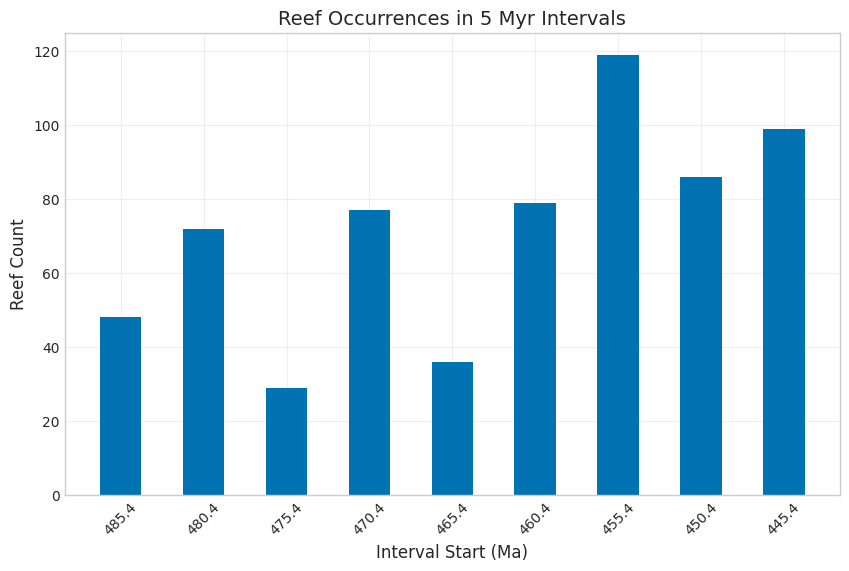

Combined PBDB summary saved to pbdb_bins_20250401_042709/combined_summary_5myr_bins.csv


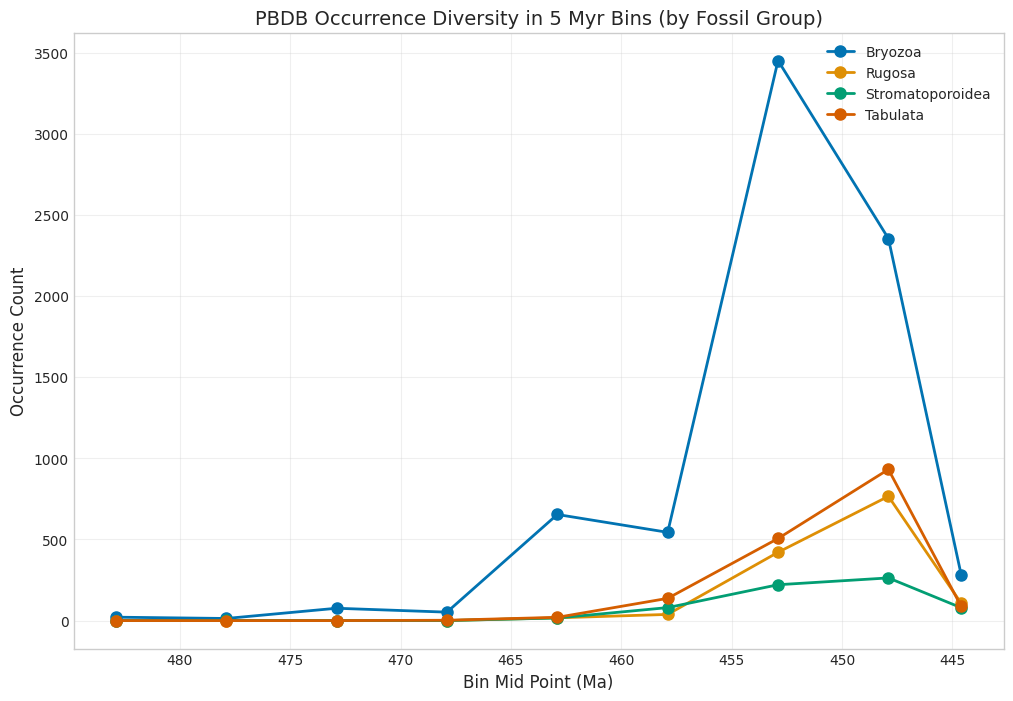


==== Extended Correlation Analysis ====

Correlation Results (Macrostrat carbonate area vs occurrence counts):


,Comparison,r,p
0,PBDB Bryozoa,0.682038,0.062419
1,PBDB Rugosa,0.862518,0.005845
2,PBDB Stromatoporoidea,0.888173,0.003209
3,PBDB Tabulata,0.899954,0.002319
4,PBDB Total,0.783531,0.021420
5,Reef Occurrence,0.598240,0.117196


In [ ]:
#@title Cell 5: 5-Myr-bin Comparisons

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from io import StringIO
from google.colab import files
from scipy.stats import pearsonr
from IPython.display import display

# ----------------------------------------------------------
# Function: Process PBDB File into 5 Myr Bins (with correct taxon naming)
# ----------------------------------------------------------
def process_pbdb_file(input_file, taxon_name=None, output_dir=None):
    """
    Process a PBDB CSV file with Ordovician fossil occurrences and
    organize them into 5‐Myr time bins.
    """
    # Determine taxon based on filename if not provided
    if taxon_name is None:
        fname = input_file.lower()
        if "stromatoporoid" in fname:
            taxon_name = "Stromatoporoidea"
        elif "bryozoa" in fname:
            taxon_name = "Bryozoa"
        elif "rugosa" in fname:
            taxon_name = "Rugosa"
        elif "tabulata" in fname:
            taxon_name = "Tabulata"
        else:
            taxon_name = "Unknown"

    print(f"Processing {taxon_name} file: {input_file}")

    if output_dir is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = f"pbdb_bins_{timestamp}"
    taxon_output_dir = os.path.join(output_dir, taxon_name)
    if not os.path.exists(taxon_output_dir):
        os.makedirs(taxon_output_dir)

    # Define Ordovician period boundaries
    ordovician_start = 485.4  # Ma
    ordovician_end = 443.8    # Ma

    # Create 5‐Myr bins
    bins = []
    current_age = ordovician_start
    while current_age > ordovician_end:
        bin_start = current_age
        bin_end = max(current_age - 5, ordovician_end)
        bins.append({
            "start_ma": bin_start,
            "end_ma": bin_end,
            "label": f"{bin_start:.1f}-{bin_end:.1f} Ma",
            "occurrences": []
        })
        current_age = bin_end
    print(f"Created {len(bins)} time bins for the Ordovician period")

    try:
        with open(input_file, 'r', encoding='utf-8', errors='replace') as f:
            lines = f.readlines()

        # Identify header line by searching for key age-related strings
        data_start_line = 0
        for i, line in enumerate(lines):
            if line.strip() == "":
                continue
            if ("occurrence_no" in line.lower() or "collection_no" in line.lower() or
                "identified_name" in line.lower() or "early_age" in line.lower() or
                "late_age" in line.lower() or "max_ma" in line.lower() or "min_ma" in line.lower()):
                data_start_line = i
                break

        header_line = lines[data_start_line].strip()
        headers = [h.strip() for h in header_line.split(',')]

        # Look for age-related columns (any column with 'age' or 'ma' in its name)
        age_col_indices = [i for i, h in enumerate(headers) if ('age' in h.lower() or 'ma' in h.lower())]
        if not age_col_indices:
            print("Warning: No age-related columns found in headers")
            print(f"Headers found: {headers}")
            return None

        all_occurrences = []
        # Process data rows
        for i in range(data_start_line + 1, len(lines)):
            line = lines[i].strip()
            if not line:
                continue
            fields = line.split(',')
            if len(fields) < max(age_col_indices) + 1:
                continue
            age_values = []
            for idx in age_col_indices:
                try:
                    age = float(fields[idx])
                    age_values.append(age)
                except:
                    continue
            if not age_values:
                continue
            median_age = sum(age_values) / len(age_values)
            occurrence_data = {'line': line, 'age': median_age}
            all_occurrences.append(occurrence_data)
            for bin_data in bins:
                if bin_data["end_ma"] <= median_age <= bin_data["start_ma"]:
                    bin_data["occurrences"].append(occurrence_data)
                    break

        summary_data = []
        for bin_data in bins:
            bin_count = len(bin_data["occurrences"])
            print(f"{bin_data['label']}: {bin_count} occurrences")
            summary_data.append({
                "taxon": taxon_name,
                "bin_start_ma": bin_data["start_ma"],
                "bin_end_ma": bin_data["end_ma"],
                "bin_mid_point": (bin_data["start_ma"] + bin_data["end_ma"]) / 2,
                "bin_label": bin_data["label"],
                "occurrence_count": bin_count
            })
            if bin_count > 0:
                bin_file = os.path.join(taxon_output_dir, f"bin_{bin_data['start_ma']:.1f}_{bin_data['end_ma']:.1f}_Ma.csv")
                with open(bin_file, 'w', newline='', encoding='utf-8') as f:
                    f.write(header_line + '\n')
                    for occurrence in bin_data["occurrences"]:
                        f.write(occurrence["line"] + '\n')
                print(f"Saved {bin_count} occurrences to {bin_file}")

        summary_file = os.path.join(taxon_output_dir, f"{taxon_name}_summary_5myr_bins.csv")
        pd.DataFrame(summary_data).to_csv(summary_file, index=False)
        print(f"\nSummary saved to {summary_file}")
        total_binned = sum(len(b["occurrences"]) for b in bins)
        print(f"Total binned: {total_binned} out of {len(all_occurrences)} occurrences")
        return {
            "taxon": taxon_name,
            "bins": bins,
            "summary_data": summary_data,
            "total_occurrences": len(all_occurrences),
            "binned_occurrences": total_binned
        }
    except Exception as e:
        print(f"Error processing file: {e}")
        return None

# ----------------------------------------------------------
# Function: Create Diversity Plot for PBDB Data (Aggregated by Fossil)
# ----------------------------------------------------------
def create_diversity_plot(summary_data, output_dir):
    df = pd.DataFrame(summary_data)
    # Use pivot_table with sum aggregation to handle duplicate bin midpoints
    pivot_df = df.pivot_table(index='bin_mid_point', columns='taxon', values='occurrence_count', aggfunc='sum')
    pivot_df = pivot_df.sort_index(ascending=False)
    plt.figure(figsize=(12, 8))
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], 'o-', linewidth=2, markersize=8, label=col)
    plt.xlabel('Bin Mid Point (Ma)', fontsize=12)
    plt.ylabel('Occurrence Count', fontsize=12)
    plt.title('PBDB Occurrence Diversity in 5 Myr Bins (by Fossil Group)', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.gca().invert_xaxis()
    plt.savefig(os.path.join(output_dir, "pbdb_diversity_plot.png"), dpi=300, bbox_inches='tight')
    plt.show()

# ----------------------------------------------------------
# Combined Upload and Processing Function
# ----------------------------------------------------------
def upload_and_process_files():
    print("Please upload your CSV files (PBDB files and/or Reef Occurrence file) in one go:")
    uploaded = files.upload()  # Upload without multiple=True
    if not uploaded:
        print("No files uploaded.")
        return

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"pbdb_bins_{timestamp}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Global lists for accumulating PBDB summary data and reef summary
    global all_summary_data, reef_summary
    all_summary_data = []
    reef_summary = None

    for filename, file_content in uploaded.items():
        fname = filename.lower()
        # Write file to disk for processing
        with open(filename, 'wb') as f:
            f.write(file_content)
        if "reef" in fname:
            print(f"Processing reef occurrence file: {filename}")
            try:
                df_reef = pd.read_csv(StringIO(file_content.decode('utf-8', errors='replace')))
            except Exception as e:
                print(f"Error reading reef occurrence CSV {filename}: {e}")
                continue
            intervals = [
                (485.4, 480.4),
                (480.4, 475.4),
                (475.4, 470.4),
                (470.4, 465.4),
                (465.4, 460.4),
                (460.4, 455.4),
                (455.4, 450.4),
                (450.4, 445.4),
                (445.4, 443.8),
            ]
            reef_results = []
            for start, end in intervals:
                overlapping = df_reef.apply(lambda row: not (row['max_ma'] < end or row['min_ma'] > start), axis=1)
                count = overlapping.sum()
                reef_results.append({
                    "interval_start": start,
                    "interval_end": end,
                    "reef_count": int(count)
                })
            reef_df = pd.DataFrame(reef_results)
            reef_df['bin_mid'] = ((reef_df['interval_start'] + reef_df['interval_end'])/2).round(1)
            reef_summary = reef_df.copy()  # Store for correlations
            print("Reef count per interval:")
            display(reef_df)
            plt.figure(figsize=(10, 6))
            plt.bar(reef_df['interval_start'].astype(str), reef_df['reef_count'], width=0.5)
            plt.xlabel('Interval Start (Ma)', fontsize=12)
            plt.ylabel('Reef Count', fontsize=12)
            plt.title('Reef Occurrences in 5 Myr Intervals', fontsize=14)
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            plt.show()
        elif "pbdb" in fname:
            result = process_pbdb_file(filename, output_dir=output_dir)
            if result:
                all_summary_data.extend(result["summary_data"])
        else:
            print(f"File {filename} did not match expected keywords ('pbdb' or 'reef'). Skipping.")

    if all_summary_data:
        combined_summary_file = os.path.join(output_dir, "combined_summary_5myr_bins.csv")
        pd.DataFrame(all_summary_data).to_csv(combined_summary_file, index=False)
        print(f"Combined PBDB summary saved to {combined_summary_file}")
        create_diversity_plot(all_summary_data, output_dir)
    else:
        print("No PBDB files processed.")

    # ----------------------------------------------------------
    # PART 3: Extended Correlation Analysis
    # ----------------------------------------------------------
    print("\n==== Extended Correlation Analysis ====")
    results = []
    pbdb_df = pd.DataFrame(all_summary_data)

    # 1. Correlation for each PBDB fossil group individually
    taxa = pbdb_df['taxon'].unique()
    for taxon in taxa:
        df_taxon = pbdb_df[pbdb_df['taxon'] == taxon].copy()
        # Group by rounded bin midpoints
        df_taxon_grouped = df_taxon.groupby(df_taxon['bin_mid_point'].round(1))['occurrence_count'].sum().reset_index()
        df_taxon_grouped.rename(columns={'bin_mid_point': 'bin_mid'}, inplace=True)
        merged_taxon = pd.merge(macrostrat_5myr_summary[['bin_mid','carbonate_area_km2']],
                                df_taxon_grouped, on='bin_mid', how='inner')
        if len(merged_taxon) >= 2:
            r, p = pearsonr(merged_taxon['carbonate_area_km2'], merged_taxon['occurrence_count'])
            results.append({'Comparison': f"PBDB {taxon}", 'r': r, 'p': p})
        else:
            results.append({'Comparison': f"PBDB {taxon}", 'r': np.nan, 'p': np.nan})

    # 2. Correlation for total PBDB occurrences
    pbdb_total = pbdb_df.groupby(pbdb_df['bin_mid_point'].round(1))['occurrence_count'].sum().reset_index()
    pbdb_total.rename(columns={'bin_mid_point': 'bin_mid'}, inplace=True)
    merged_total = pd.merge(macrostrat_5myr_summary[['bin_mid','carbonate_area_km2']], pbdb_total, on='bin_mid', how='inner')
    if len(merged_total) >= 2:
        r_total, p_total = pearsonr(merged_total['carbonate_area_km2'], merged_total['occurrence_count'])
        results.append({'Comparison': "PBDB Total", 'r': r_total, 'p': p_total})
    else:
        results.append({'Comparison': "PBDB Total", 'r': np.nan, 'p': np.nan})

    # 3. Correlation for Reef Occurrences
    if reef_summary is not None:
        merged_reef = pd.merge(macrostrat_5myr_summary[['bin_mid','carbonate_area_km2']], reef_summary[['bin_mid','reef_count']], on='bin_mid', how='inner')
        if len(merged_reef) >= 2:
            r_reef, p_reef = pearsonr(merged_reef['carbonate_area_km2'], merged_reef['reef_count'])
            results.append({'Comparison': "Reef Occurrence", 'r': r_reef, 'p': p_reef})
        else:
            results.append({'Comparison': "Reef Occurrence", 'r': np.nan, 'p': np.nan})
    else:
        results.append({'Comparison': "Reef Occurrence", 'r': np.nan, 'p': np.nan})

    correlation_df = pd.DataFrame(results)
    print("\nCorrelation Results (Macrostrat carbonate area vs occurrence counts):")
    display(correlation_df)

# Run the combined upload and processing function
upload_and_process_files()
